In [1]:
# ====================
# 1. Import packages
# ====================
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import skew, kurtosis

warnings.filterwarnings('ignore')

In [2]:
# ====================
# 2. Load Data
# ====================
data_folder = Path("./39_Training_Dataset")
train_info = pd.read_csv(data_folder / "train_info.csv")
train_data_folder = data_folder / "train_data"

def load_sensor_data(filepath):
    data = []
    with open(filepath, "r") as f:
        for idx, line in enumerate(f.readlines()):
            if idx == 0 or line.strip() == "":
                continue
            parts = line.strip().split()
            if len(parts) >= 6:
                data.append([int(x) for x in parts[:6]])
    return np.array(data)

def segment_swings(sensor_data, n_swings=27):
    swing_indices = np.linspace(0, len(sensor_data), n_swings+1, dtype=int)
    swings = []
    for i in range(n_swings):
        swings.append(sensor_data[swing_indices[i]:swing_indices[i+1]])
    return swings

def extract_features_from_swing(swing_data):
    features = {}
    for i, axis in enumerate(['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']):
        data_axis = swing_data[:, i]
        features[f'{axis}_mean'] = np.mean(data_axis)
        features[f'{axis}_std'] = np.std(data_axis)
        features[f'{axis}_max'] = np.max(data_axis)
        features[f'{axis}_min'] = np.min(data_axis)
        features[f'{axis}_skew'] = skew(data_axis)
        features[f'{axis}_kurtosis'] = kurtosis(data_axis)

    acc_magnitude = np.linalg.norm(swing_data[:, 0:3], axis=1)
    gyro_magnitude = np.linalg.norm(swing_data[:, 3:6], axis=1)

    features['acc_mag_mean'] = np.mean(acc_magnitude)
    features['gyro_mag_mean'] = np.mean(gyro_magnitude)

    mid = swing_data.shape[0] // 2
    features['acc_early_vs_late_mean_ratio'] = (np.mean(acc_magnitude[:mid]) + 1e-6) / (np.mean(acc_magnitude[mid:]) + 1e-6)

    return features

def aggregate_swing_features(swing_features_df):
    session_features = {}
    for col in swing_features_df.columns:
        session_features[f'{col}_mean'] = swing_features_df[col].mean()
        session_features[f'{col}_std'] = swing_features_df[col].std()
        session_features[f'{col}_min'] = swing_features_df[col].min()
        session_features[f'{col}_max'] = swing_features_df[col].max()

    num_swings = len(swing_features_df)
    early = swing_features_df.iloc[:num_swings//3]
    late = swing_features_df.iloc[-num_swings//3:]
    for col in swing_features_df.columns:
        session_features[f'{col}_early_mean'] = early[col].mean()
        session_features[f'{col}_late_mean'] = late[col].mean()

    return session_features

def process_one_file(file_path):
    try:
        data = load_sensor_data(file_path)
        swings = segment_swings(data)
        swing_feats = [extract_features_from_swing(s) for s in swings]
        swing_feats_df = pd.DataFrame(swing_feats)
        session_feats = aggregate_swing_features(swing_feats_df)
        return session_feats
    except Exception as e:
        print(f"Failed: {file_path.name} - {e}")
        return None

In [3]:
# Build dataset
X_list, y_list = [], []
for file_path in tqdm(sorted(train_data_folder.glob("*.txt"))):
    uid = int(file_path.stem)
    info_row = train_info[train_info['unique_id'] == uid]
    if info_row.empty:
        continue
    session_feats = process_one_file(file_path)
    if session_feats is None:
        continue
    mode = int(info_row['mode'].values[0])
    for m in range(1, 11):
        session_feats[f'mode_{m}'] = 1 if mode == m else 0
    X_list.append(session_feats)
    y_list.append(info_row[['gender', 'hold racket handed', 'play years', 'level']].iloc[0])

X = pd.DataFrame(X_list)
y = pd.DataFrame(y_list)

  0%|          | 0/1955 [00:00<?, ?it/s]

In [4]:
# ====================
# 3. Feature Engineering (play years new features)
# ====================

# (only add later when training play years)

def add_play_years_features_from_X(df):
    acc_magnitude = np.sqrt(df['Ax_mean_mean']**2 + df['Ay_mean_mean']**2 + df['Az_mean_mean']**2)
    gyro_magnitude = np.sqrt(df['Gx_mean_mean']**2 + df['Gy_mean_mean']**2 + df['Gz_mean_mean']**2)

    df['acc_energy_total'] = acc_magnitude ** 2
    df['gyro_energy_total'] = gyro_magnitude ** 2
    df['acc_vs_gyro_energy_ratio'] = acc_magnitude / (gyro_magnitude + 1e-6)
    df['acc_early_mean'] = df['acc_mag_mean_early_mean']
    df['acc_late_mean'] = df['acc_mag_mean_late_mean']
    df['early_late_energy_ratio'] = df['acc_early_mean'] / (df['acc_late_mean'] + 1e-6)
    return df

# ====================
# 4. Train LightGBM per target
# ====================

feature_importances = {}

# Train one target
def train_lightgbm_one_target(X, X_scaled, y_target, folds, target_name):
    is_binary = len(np.unique(y_target)) == 2
    if is_binary:
        oof_preds = np.zeros(len(X_scaled))
    else:
        num_classes = len(np.unique(y_target))
        oof_preds = np.zeros((len(X_scaled), num_classes))

    print(f"\n🎯 Training {target_name}...")

    feature_importance_df = pd.DataFrame()

    for fold_id, (train_idx, val_idx) in enumerate(folds):
        print(f"📂 Fold {fold_id}:")
        
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y_target[train_idx], y_target[val_idx]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dval = lgb.Dataset(X_val, label=y_val)

        # custom params
        if target_name == 'gender':
            params = {'learning_rate': 0.171,
                      'num_leaves': 239,
                      'max_depth': 16,
                      'min_child_samples': 32,
                      'feature_fraction': 0.977,
                      'bagging_fraction': 0.511,
                      'bagging_freq': 2,
                      'reg_alpha': 0.0071,
                      'reg_lambda': 0.0012}
        elif target_name == 'hold racket handed':
            params = {'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.05, 'boosting_type': 'gbdt', 'verbosity': -1, 'seed': 42}
        elif target_name == 'level':
            params = {'objective': 'multiclass', 'metric': 'multi_logloss', 'learning_rate': 0.05, 'boosting_type': 'gbdt', 'verbosity': -1, 'seed': 42, 'num_class': len(np.unique(y_target))}
        elif target_name == 'play years':
            params = {'objective': 'multiclass', 'metric': 'multi_logloss', 'learning_rate': 0.05, 'boosting_type': 'gbdt', 'verbosity': -1, 'seed': 42, 'num_class': len(np.unique(y_target)), 'class_weight': 'balanced'}

        model = lgb.train(params, dtrain, num_boost_round=3000,
                          valid_sets=[dtrain, dval],
                          callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)])

        preds = model.predict(X_val)
        if is_binary:
            oof_preds[val_idx] = preds
        else:
            oof_preds[val_idx] = preds

        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = X.columns
        fold_importance_df['importance'] = model.feature_importance()
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # calc oof auc
    if is_binary:
        auc = roc_auc_score(y_target, oof_preds)
    else:
        auc = roc_auc_score(y_target, oof_preds, multi_class='ovr')
    print(f"✅ {target_name} OOF AUC = {auc:.5f}")

    feature_importances[target_name] = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
    return oof_preds, auc

In [5]:
# ====================
# 5. Final Training Pipeline
# ====================

# 5.1 Encode labels
y_encoded = {}
for col in ['gender', 'hold racket handed', 'play years', 'level']:
    y_encoded[col] = LabelEncoder().fit_transform(y[col])

# 5.2 Prepare folds
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y['gender']))

In [6]:
# 5.3 Train gender first (full features)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

oof_gender, auc_gender = train_lightgbm_one_target(X, X_scaled, y_encoded['gender'], folds, 'gender')


🎯 Training gender...
📂 Fold 0:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59268
[LightGBM] [Info] Number of data points in the train set: 1564, number of used features: 241
[LightGBM] [Info] Start training from score 0.168159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [7]:

# 5.4 Select important features
gender_feat_importance = feature_importances['gender'].sort_values(ascending=False)
cumulative_importance = gender_feat_importance.cumsum()
important_features = cumulative_importance[cumulative_importance <= 0.95].index.tolist()

# Fallback if empty (select top 30)
if len(important_features) == 0:
    important_features = gender_feat_importance.head(30).index.tolist()

X_selected = X[important_features]
X_selected_scaled = scaler.fit_transform(X_selected)

In [8]:
# 5.5 Train hold racket handed & level
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_selected, y['hold racket handed']))
oof_hand, auc_hand = train_lightgbm_one_target(X_selected, X_selected_scaled, y_encoded['hold racket handed'], folds, 'hold racket handed')


🎯 Training hold racket handed...
📂 Fold 0:
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 1	valid_1's auc: 0.990308
[200]	training's auc: 1	valid_1's auc: 0.990351
Early stopping, best iteration is:
[160]	training's auc: 1	valid_1's auc: 0.991686
📂 Fold 1:
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 1	valid_1's auc: 0.992289
[200]	training's auc: 1	valid_1's auc: 0.997415
[300]	training's auc: 1	valid_1's auc: 0.998062
Early stopping, best iteration is:
[268]	training's auc: 1	valid_1's auc: 0.998105
📂 Fold 2:
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 1	valid_1's auc: 0.984234
[200]	training's auc: 1	valid_1's auc: 0.989661
[300]	training's auc: 1	valid_1's auc: 0.991858
[400]	training's auc: 1	valid_1's auc: 0.993151
Early stopping, best iteration is:
[411]	training's auc: 1	valid_1's auc: 0.993323
📂 Fold 3:
Training until validation scores don't improve for 50 rounds
[

In [9]:
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_selected, y['level']))
oof_level, auc_level = train_lightgbm_one_target(X_selected, X_selected_scaled, y_encoded['level'], folds, 'level')


🎯 Training level...
📂 Fold 0:
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.0192238	valid_1's multi_logloss: 0.326875
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.0179599	valid_1's multi_logloss: 0.325788
📂 Fold 1:
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.0181101	valid_1's multi_logloss: 0.338732
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.00838917	valid_1's multi_logloss: 0.334613
📂 Fold 2:
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.0196096	valid_1's multi_logloss: 0.272685
Early stopping, best iteration is:
[140]	training's multi_logloss: 0.00511724	valid_1's multi_logloss: 0.266142
📂 Fold 3:
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.0170284	valid_1's multi_logloss: 0.364405
Early stopping, best iteration is:
[128]	training's mult

In [10]:
X_selected.columns

Index(['Ax_mean_std', 'Ax_skew_std', 'Gx_min_std', 'Gz_mean_early_mean',
       'Az_kurtosis_min', 'Ay_mean_max', 'Gx_skew_std', 'Ay_skew_min',
       'Ax_max_std', 'Gz_mean_mean', 'Az_mean_std', 'Gy_skew_std',
       'Gy_kurtosis_std', 'Az_min_max', 'Ay_skew_mean', 'acc_mag_mean_std',
       'Ay_skew_early_mean', 'Gz_skew_std', 'Az_mean_max',
       'Ay_kurtosis_early_mean', 'Az_mean_early_mean', 'Ay_mean_std',
       'Az_kurtosis_mean', 'Gz_mean_max', 'acc_early_vs_late_mean_ratio_max',
       'Gy_skew_max', 'Ay_kurtosis_late_mean', 'Az_std_min',
       'Az_kurtosis_late_mean', 'acc_mag_mean_min'],
      dtype='object')

In [11]:
# 5.6 Special for play years ➔ add new features
X_play_years = X.copy()
X_play_years = add_play_years_features_from_X(X_play_years)

# Optionally reselect only the original selected + new ones (optional)
play_years_cols = important_features + [
    'acc_energy_total', 'gyro_energy_total', 'acc_vs_gyro_energy_ratio',
    'acc_early_mean', 'acc_late_mean', 'early_late_energy_ratio'
]
play_years_cols = [col for col in play_years_cols if col in X_play_years.columns]

X_selected_plus_play_years = X_play_years[play_years_cols]
X_selected_plus_play_years_scaled = scaler.fit_transform(X_selected_plus_play_years)

folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_selected_plus_play_years, y['play years']))
oof_years, auc_years = train_lightgbm_one_target(X_selected_plus_play_years, X_selected_plus_play_years_scaled, y_encoded['play years'], folds, 'play years')



🎯 Training play years...
📂 Fold 0:
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.0295502	valid_1's multi_logloss: 0.254788
[200]	training's multi_logloss: 0.00144985	valid_1's multi_logloss: 0.250907
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0052293	valid_1's multi_logloss: 0.240617
📂 Fold 1:
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.0287697	valid_1's multi_logloss: 0.290655
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.0169289	valid_1's multi_logloss: 0.287524
📂 Fold 2:
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.0299678	valid_1's multi_logloss: 0.281237
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.013942	valid_1's multi_logloss: 0.267998
📂 Fold 3:
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.0286479	valid_1's m

In [12]:
# ====================
# 6. Report
# ====================
print("\n🎯 Final CV Results:")
print(f"Gender AUC = {auc_gender:.5f}")
print(f"Hold Racket Handed AUC = {auc_hand:.5f}")
print(f"Level AUC = {auc_level:.5f}")
print(f"Play Years AUC = {auc_years:.5f}")


🎯 Final CV Results:
Gender AUC = 0.99354
Hold Racket Handed AUC = 0.98606
Level AUC = 0.97821
Play Years AUC = 0.98257


In [13]:
# =========================
# Apply Feature Processing (FIXED)
# =========================

from scipy.special import expit

# Create proper MinMaxScaler for selected features
scaler_selected = MinMaxScaler()
X_selected_scaled = scaler_selected.fit_transform(X_selected)

# For Play Years
X_play_years_full = add_play_years_features_from_X(X.copy())
X_selected_plus_play_years = X_play_years_full[important_features + [
    'acc_energy_total', 'gyro_energy_total', 'acc_vs_gyro_energy_ratio',
    'acc_early_mean', 'acc_late_mean', 'early_late_energy_ratio'
]]

scaler_play_years = MinMaxScaler()
X_selected_plus_play_years_scaled = scaler_play_years.fit_transform(X_selected_plus_play_years)

In [15]:
from tqdm.auto import tqdm

test_info = pd.read_csv("39_Test_Dataset/test_info.csv")

# === Prepare test data ===
X_test_list, test_uid_list = [], []

for file_path in tqdm(sorted((Path("39_Test_Dataset/test_data")).glob("*.txt")), desc="🔍 Processing test"):
    uid = int(file_path.stem)
    data = process_one_file(file_path)
    if data:
        row = pd.Series(data)
        mode = test_info[test_info['unique_id'] == uid]['mode'].values[0]
        for m in range(1, 11):
            row[f'mode_{m}'] = 1 if mode == m else 0
        X_test_list.append(row)
        test_uid_list.append(uid)

X_test = pd.DataFrame(X_test_list)
X_test.index = test_uid_list

In [16]:
# === Prepare test features (aligned!) ===
X_test_selected = X_test[important_features]
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

X_test_play_years = add_play_years_features_from_X(X_test.copy())
X_test_play_years = X_test_play_years[X_selected_plus_play_years.columns]
X_test_play_years_scaled = scaler_play_years.transform(X_test_play_years)


In [18]:
# === Define Model Parameters ===

# Gender (binary classification, optimized via Optuna)
params_gender = {
    'learning_rate': 0.171,
    'num_leaves': 239,
    'max_depth': 16,
    'min_child_samples': 32,
    'feature_fraction': 0.977,
    'bagging_fraction': 0.511,
    'bagging_freq': 2,
    'reg_alpha': 0.0071,
    'reg_lambda': 0.0012,
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42
}

# Hold racket handed (binary classification)
params_hand = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42
}

# Level (multiclass classification)
params_level = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42,
    'num_class': len(np.unique(y_encoded['level']))
}

# Play years (multiclass classification, imbalance)
params_years = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'seed': 42,
    'num_class': len(np.unique(y_encoded['play years'])),
    'class_weight': 'balanced'
}

In [19]:
# === Retrain Final Models ===
model_gender = lgb.train(params_gender, lgb.Dataset(X_selected_scaled, label=y_encoded['gender']), num_boost_round=3000)
model_hand = lgb.train(params_hand, lgb.Dataset(X_selected_scaled, label=y_encoded['hold racket handed']), num_boost_round=3000)
model_level = lgb.train(params_level, lgb.Dataset(X_selected_scaled, label=y_encoded['level']), num_boost_round=3000)
model_years = lgb.train(params_years, lgb.Dataset(X_selected_plus_play_years_scaled, label=y_encoded['play years']), num_boost_round=3000)


In [20]:
# === Predict on test ===
pred_gender = expit(model_gender.predict(X_test_selected_scaled))
pred_hand = expit(model_hand.predict(X_test_selected_scaled))
pred_level = model_level.predict(X_test_selected_scaled)
pred_years = model_years.predict(X_test_play_years_scaled)

In [21]:
# === Align predictions with sample_submission
sample_submission = pd.read_csv("39_Test_Dataset/sample_submission.csv")
submission = pd.DataFrame()
submission['unique_id'] = test_uid_list
submission['gender'] = pred_gender
submission['hold racket handed'] = pred_hand

for i in range(pred_years.shape[1]):
    submission[f'play years_{i}'] = pred_years[:, i]
for i in range(pred_level.shape[1]):
    submission[f'level_{i+2}'] = pred_level[:, i]

In [22]:
# Ensure proper row order
submission = submission.set_index('unique_id').loc[sample_submission['unique_id']].reset_index()


In [23]:
# Final validation
assert submission.shape == sample_submission.shape
assert list(submission.columns) == list(sample_submission.columns)
assert not submission.isnull().any().any()
assert ((submission.drop(columns='unique_id') >= 0) & (submission.drop(columns='unique_id') <= 1)).all().all()


In [24]:
# Save
submission.to_csv("submission.csv", index=False, float_format="%.10f")
print("✅ Fixed submission.csv saved and validated")

✅ Fixed submission.csv saved and validated


# Validate that Test dataset preprocessing is in align with Training

In [25]:
assert list(X_test_selected.columns) == list(X_selected.columns), "❌ Feature columns mismatch!"

In [26]:
print("Scaler (selected) feature count:", scaler_selected.n_features_in_)
print("Train X_selected shape:", X_selected.shape)
print("Test X_test_selected shape:", X_test_selected.shape)


Scaler (selected) feature count: 30
Train X_selected shape: (1955, 30)
Test X_test_selected shape: (1430, 30)


In [32]:
X_selected.columns

Index(['Ax_mean_std', 'Ax_skew_std', 'Gx_min_std', 'Gz_mean_early_mean',
       'Az_kurtosis_min', 'Ay_mean_max', 'Gx_skew_std', 'Ay_skew_min',
       'Ax_max_std', 'Gz_mean_mean', 'Az_mean_std', 'Gy_skew_std',
       'Gy_kurtosis_std', 'Az_min_max', 'Ay_skew_mean', 'acc_mag_mean_std',
       'Ay_skew_early_mean', 'Gz_skew_std', 'Az_mean_max',
       'Ay_kurtosis_early_mean', 'Az_mean_early_mean', 'Ay_mean_std',
       'Az_kurtosis_mean', 'Gz_mean_max', 'acc_early_vs_late_mean_ratio_max',
       'Gy_skew_max', 'Ay_kurtosis_late_mean', 'Az_std_min',
       'Az_kurtosis_late_mean', 'acc_mag_mean_min'],
      dtype='object')

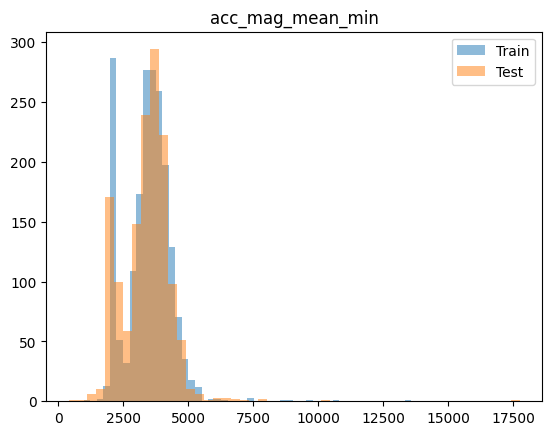

In [34]:
import matplotlib.pyplot as plt

# col = 'acc_mag_mean_std'  # pick one of your selected features
col = 'acc_mag_mean_min'
plt.hist(X_selected[col], bins=50, alpha=0.5, label='Train')
plt.hist(X_test_selected[col], bins=50, alpha=0.5, label='Test')
plt.title(col)
plt.legend()
plt.show()


In [28]:
assert list(submission['unique_id']) == list(sample_submission['unique_id']), "❌ ID row order mismatch!"


In [29]:
submission = submission.set_index('unique_id').loc[sample_submission['unique_id']].reset_index()


In [30]:
assert ((submission.drop(columns='unique_id') >= 0) & (submission.drop(columns='unique_id') <= 1)).all().all(), "❌ Found invalid probabilities!"


In [31]:
print("Train row:\n", X_selected.iloc[0])
print("Test row:\n", X_test_selected.iloc[0])


Train row:
 Ax_mean_std                          293.597768
Ax_skew_std                            0.454051
Gx_min_std                          2303.820024
Gz_mean_early_mean                  -722.531112
Az_kurtosis_min                       -1.509341
Ay_mean_max                         -753.822581
Gx_skew_std                            0.238170
Ay_skew_min                           -1.646947
Ax_max_std                           473.007589
Gz_mean_mean                         177.458586
Az_mean_std                          349.107205
Gy_skew_std                            0.256652
Gy_kurtosis_std                        0.348771
Az_min_max                         -3587.000000
Ay_skew_mean                          -0.127041
acc_mag_mean_std                     499.142752
Ay_skew_early_mean                    -0.168338
Gz_skew_std                            0.225551
Az_mean_max                         1085.885246
Ay_kurtosis_early_mean                -0.546708
Az_mean_early_mean          